# Feature selection with Random Forest

We are using the feature selection from feature importance of basic RF clf. 


In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
from sklearn.ensemble import RandomForestClassifier

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

# others
import os


In [2]:
print(os.listdir("../input"))

['00_injury_GBM_onehot_corr90_dropped.csv', '00_injury_GBM_onehot_corr90_dropped_special.csv', '00_injury_onehot_corr90_dropped_replace_missing.csv', '00_injury_onehot_corr90_dropped_replace_missing_special.csv', '00_injury_train_people_vehicle_corrs_removed.csv', '00_injury_train_people_vehicle_corrs_removed.zip', '00_injury_train_people_vehicle_missing_70.csv', 'cumsum.csv', 'injury_onehot_corr90_dropped.csv', 'injury_train_people_vehicle_corrs_removed.csv', 'injury_train_people_vehicle_corrs_removed.zip', 'injury_train_people_vehicle_raw.csv', 'Traffic_Crashes_-_Crashes.csv', 'Traffic_Crashes_-_People.csv', 'Traffic_Crashes_-_Vehicles.csv', 'train_control_damage.csv', 'train_new.csv', 'train_people_vehicle_corrs_removed.csv', 'train_people_vehicle_raw.csv']


In [11]:
#read in data
categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
                'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
                'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
                'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
                'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
                'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                'MOST_SEVERE_INJURY', 'BEAT_OF_OCCURRENCE','CRASH_HOUR','CRASH_MONTH','CRASH_DAY_OF_WEEK','YEAR']
dtypes = dict.fromkeys(categoricals, 'object')


train = pd.read_csv('../input/train_people_vehicle_corrs_removed.csv', dtype = dtypes)
train.info()
train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207101 entries, 0 to 207100
Columns: 129 entries, RD_NO to vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
dtypes: float64(100), int64(3), object(26)
memory usage: 203.8+ MB


(207101, 129)

There are 207,101 rows and 129 features in the dataset

In [12]:
# save the ids and target
train_labels = train['TARGET']
train_ids = train['RD_NO']

we are dropping some variables with date and IDs and location information which are not important for modeling.

In [15]:
# drop variables 
drop_columns =  ['RD_NO','CRASH_DATE', 'DATE_POLICE_NOTIFIED', 'STREET_NAME','STREET_NO','BEAT_OF_OCCURRENCE','LATITUDE','LONGITUDE','LOCATION']
train = train.drop(columns=drop_columns)
train.shape

(207101, 120)

In [16]:
train.shape

(207101, 120)

Our data set is composed of categorical variables the most. it will take some time to run the model due to the size of features. 

## Remove Collinear Variables

Since we haved added some numrical features from other tables. We are checing collinearity.
Collinear variables can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step. We will establish an admittedly arbitrary threshold for removing collinear variables, and then remove one out of any pair of variables that is above that threshold.

In [17]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,TARGET,...,vehicle_VEHICLE_TYPE_OTHER VEHICLE WITH TRAILER_count,vehicle_VEHICLE_TYPE_PASSENGER_count,vehicle_VEHICLE_TYPE_PICKUP_count,vehicle_VEHICLE_TYPE_SNOWMOBILE_count,vehicle_VEHICLE_TYPE_SPORT UTILITY VEHICLE (SUV)_count,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
POSTED_SPEED_LIMIT,1.000000,0.049491,0.068983,0.006308,0.027931,0.053116,0.036796,0.093795,NaN,0.031343,...,0.002673,0.072215,0.009332,0.001294,0.007552,0.008286,0.003318,0.016044,0.061501,0.009958
NUM_UNITS,0.049491,1.000000,0.102762,0.002373,0.039796,0.075840,0.060803,0.174629,NaN,0.074404,...,0.000756,0.398321,0.060508,0.000295,0.108460,0.040797,0.006118,0.011399,0.056225,0.075619
INJURIES_TOTAL,0.068983,0.102762,1.000000,0.097241,0.344159,0.756336,0.582305,0.176321,NaN,0.105215,...,0.005938,0.030276,0.004151,0.001599,0.000874,0.017818,0.003904,0.022661,0.080565,0.006614
INJURIES_FATAL,0.006308,0.002373,0.097241,1.000000,0.045003,0.018826,0.005692,0.030544,NaN,0.015745,...,0.001638,0.003834,0.001761,0.000144,0.003871,0.004269,0.011284,0.000339,0.007714,0.003099
INJURIES_INCAPACITATING,0.027931,0.039796,0.344159,0.045003,1.000000,0.047690,0.006683,0.080003,NaN,0.043203,...,0.003580,0.003333,0.002083,0.000588,0.004860,0.006834,0.001189,0.012257,0.029306,0.002417


In [18]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,POSTED_SPEED_LIMIT,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,TARGET,...,vehicle_VEHICLE_TYPE_OTHER VEHICLE WITH TRAILER_count,vehicle_VEHICLE_TYPE_PASSENGER_count,vehicle_VEHICLE_TYPE_PICKUP_count,vehicle_VEHICLE_TYPE_SNOWMOBILE_count,vehicle_VEHICLE_TYPE_SPORT UTILITY VEHICLE (SUV)_count,vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count,vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count,vehicle_VEHICLE_TYPE_UNKNOWN/NA_count,vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count
POSTED_SPEED_LIMIT,NaN,0.049491,0.068983,0.006308,0.027931,0.053116,0.036796,0.093795,NaN,0.031343,...,0.002673,0.072215,0.009332,0.001294,0.007552,0.008286,0.003318,0.016044,0.061501,0.009958
NUM_UNITS,NaN,NaN,0.102762,0.002373,0.039796,0.075840,0.060803,0.174629,NaN,0.074404,...,0.000756,0.398321,0.060508,0.000295,0.108460,0.040797,0.006118,0.011399,0.056225,0.075619
INJURIES_TOTAL,NaN,NaN,NaN,0.097241,0.344159,0.756336,0.582305,0.176321,NaN,0.105215,...,0.005938,0.030276,0.004151,0.001599,0.000874,0.017818,0.003904,0.022661,0.080565,0.006614
INJURIES_FATAL,NaN,NaN,NaN,NaN,0.045003,0.018826,0.005692,0.030544,NaN,0.015745,...,0.001638,0.003834,0.001761,0.000144,0.003871,0.004269,0.011284,0.000339,0.007714,0.003099
INJURIES_INCAPACITATING,NaN,NaN,NaN,NaN,NaN,0.047690,0.006683,0.080003,NaN,0.043203,...,0.003580,0.003333,0.002083,0.000588,0.004860,0.006834,0.001189,0.012257,0.029306,0.002417


In [19]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 1 columns to remove.


In [20]:
to_drop

['SAFETY_EQUIPMENT_USAGE UNKNOWN_count_norm']

In [21]:
# Drop Correlated Variables
train = train.drop(columns = to_drop)

print('Training shape: ', train.shape)

Training shape:  (207101, 119)


## Remove Missing Values
There is no right way to choose the threshold for missing values.
In this implementation, if any columns have greater than 70% missing values, they will be removed, which has been done on feature engineering process

In [22]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

LANE_CNT                                                  0.338627
people_AGE_mean                                           0.176271
REPORT_TYPE                                               0.022805
SAFETY_EQUIPMENT_USAGE UNKNOWN_count                      0.015649
SAFETY_EQUIPMENT_CHILD RESTRAINT USED IMPROPERLY_count    0.015649
dtype: float64

In [23]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
missing = list(set(train_missing))

In [24]:
f'There are {len(missing)} columns with more than 75% missing values'

'There are 0 columns with more than 75% missing values'

In [25]:
train.isnull().sum()

POSTED_SPEED_LIMIT                                       0
TRAFFIC_CONTROL_DEVICE                                   0
DEVICE_CONDITION                                         0
WEATHER_CONDITION                                        0
LIGHTING_CONDITION                                       0
                                                      ... 
vehicle_VEHICLE_TYPE_TRACTOR W/ SEMI-TRAILER_count     391
vehicle_VEHICLE_TYPE_TRACTOR W/O SEMI-TRAILER_count    391
vehicle_VEHICLE_TYPE_TRUCK - SINGLE UNIT_count         391
vehicle_VEHICLE_TYPE_UNKNOWN/NA_count                  391
vehicle_VEHICLE_TYPE_VAN/MINI-VAN_count                391
Length: 119, dtype: int64

There are some variables with NaN value. Random Forest cannot handle the missing data, We are going to replace NaN value with median or most frequent values.

In [26]:
# One Hot Encoding
features = pd.get_dummies(train)
# drop special characters: it will cause issues later

features.columns=features.columns.str.replace(r'[$]', '')
features.columns=features.columns.str.replace(r'[/]', '')
features.columns=features.columns.str.replace(r'[,]', '')
features.columns=features.columns.str.replace(r'[-]', '')
# Extract features and labels
labels = features['TARGET']
features = features.drop('TARGET', axis = 1)

# List of features for later use
feature_list = list(features.columns)

In [27]:
# Convert to numpy arrays
import numpy as np

# features = np.array(features)
# labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 2003)

In [28]:

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (155325, 372)
Training Labels Shape: (155325,)
Testing Features Shape: (51776, 372)
Testing Labels Shape: (51776,)


In [29]:
# function for replacing missing variables. 
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

X = pd.DataFrame(train_features)
train_features = DataFrameImputer().fit_transform(X)
T = pd.DataFrame(test_features)
test_features = DataFrameImputer().fit_transform(T)

In [30]:
train_features.isnull().sum()

POSTED_SPEED_LIMIT         0
NUM_UNITS                  0
INJURIES_TOTAL             0
INJURIES_FATAL             0
INJURIES_INCAPACITATING    0
                          ..
CRASH_MONTH_8              0
CRASH_MONTH_9              0
YEAR_2017                  0
YEAR_2018                  0
YEAR_2019                  0
Length: 372, dtype: int64

In [31]:
test_features.isnull().sum()

POSTED_SPEED_LIMIT         0
NUM_UNITS                  0
INJURIES_TOTAL             0
INJURIES_FATAL             0
INJURIES_INCAPACITATING    0
                          ..
CRASH_MONTH_8              0
CRASH_MONTH_9              0
YEAR_2017                  0
YEAR_2018                  0
YEAR_2019                  0
Length: 372, dtype: int64

In [32]:
test_features.shape

(51776, 372)

In [334]:
# save to csv
train.to_csv('../input/00_injury_onehot_corr90_dropped_replace_missing_special.csv')

## Feature Selection through Feature Importances
The next method we can employ for feature selection is to use the feature importances of a model. Tree-based models (and consequently ensembles of trees) can determine an "importance" for each feature by measuring the reduction in impurity for including the feature in the model. Moreover, we can use the feature importances to remove features that the model does not consider important.

we can perform our own feature removal by selecting cumulative importance at 95% first. If this leaves too many features, then we can consider removing the features with the lowest importance. 

### Examine the Default Random Forest to Determine Parameters
We will use these parameters as a starting point. I relied on the sklearn random forest documentation to determine which features to change and the available options.

In [335]:
base_clf = RandomForestClassifier(random_state = 2003, class_weight='balanced_subsample',
                                  oob_score='True',n_estimators= 1000, n_jobs=-1)



from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(base_clf.get_params()) # print nicely

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': 'True',
 'random_state': 2003,
 'verbose': 0,
 'warm_start': False}


In [336]:
base_clf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score='True',
                       random_state=2003, verbose=0, warm_start=False)

In [351]:
# evaluation for model
from sklearn import metrics as mt
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    oob_score = model.oob_score_
    report= mt.classification_report(test_labels, predictions) 
    print('***** Model Performance. *****')
    print('- Out of Bag score: {:0.4f}.'.format(oob_score))
    print('- test_labels values:',test_labels.values[0:10]) # if it is array alreay. no need to call as .values
    print('- predictions values:',predictions[0:10],'\n')
    print('<Accuracy> \n{}'.format(report))
    
    return report

In [265]:
evaluate(base_clf, test_features, test_labels)

***** Model Performance. *****
- Out of Bag eror: 0.8757.
- test_labels values: [0 0 0 0 0 0 0 0 1 0]
- predictions values: [0 0 0 0 0 0 1 0 0 0] 

<Accuracy> 
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     39041
           1       0.79      0.65      0.71     12735

    accuracy                           0.87     51776
   macro avg       0.84      0.80      0.82     51776
weighted avg       0.87      0.87      0.87     51776



'              precision    recall  f1-score   support\n\n           0       0.89      0.94      0.92     39041\n           1       0.79      0.65      0.71     12735\n\n    accuracy                           0.87     51776\n   macro avg       0.84      0.80      0.82     51776\nweighted avg       0.87      0.87      0.87     51776\n'

In [33]:

base_clf_1 = RandomForestClassifier(random_state = 2003, class_weight='balanced',
                                  oob_score='True',n_estimators= 1000, n_jobs=-1)

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(base_clf_1.get_params()) # print nicely

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': 'True',
 'random_state': 2003,
 'verbose': 0,
 'warm_start': False}


In [34]:
base_clf_1.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score='True', random_state=2003,
                       verbose=0, warm_start=False)

In [289]:
evaluate(base_clf_1, test_features, test_labels)

***** Model Performance. *****
- Out of Bag eror: 0.8754.
- test_labels values: [0 0 0 0 0 0 0 0 1 0]
- predictions values: [0 0 0 0 0 0 1 0 0 0] 

<Accuracy> 
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     39041
           1       0.79      0.66      0.72     12735

    accuracy                           0.87     51776
   macro avg       0.84      0.80      0.82     51776
weighted avg       0.87      0.87      0.87     51776



'              precision    recall  f1-score   support\n\n           0       0.89      0.94      0.92     39041\n           1       0.79      0.66      0.72     12735\n\n    accuracy                           0.87     51776\n   macro avg       0.84      0.80      0.82     51776\nweighted avg       0.87      0.87      0.87     51776\n'

Recall socore of our target INJURY(target=1) is much less than NoInjury's one due to imbalanced dataset. We have used the parameter for 'Class_weight = balanced_subsample'.

## Feture importance

In [338]:
fi_model = pd.DataFrame({'feature': feature_list,
                   'importance': base_clf.feature_importances_}).sort_values('importance', ascending = False)

In [339]:
import matplotlib.pyplot as plt
import numpy as np


plt.style.use('fivethirtyeight')
fi_model

,feature,importance
231,REPORT_TYPE_NOT ON SCENE (DESK REPORT),0.114001
232,REPORT_TYPE_ON SCENE,0.105775
235,DAMAGE_OVER 1500,0.028420
4,people_AGE_mean,0.023724
14,AIRBAG_DEPLOYED_DEPLOYED FRONT_count,0.021464
...,...,...
9,SEX_U_count,0.000000
174,LANE_CNT_19.0,0.000000
188,LANE_CNT_100.0,0.000000
209,LANE_CNT_902,0.000000


In [340]:
# feature_importance top 15
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

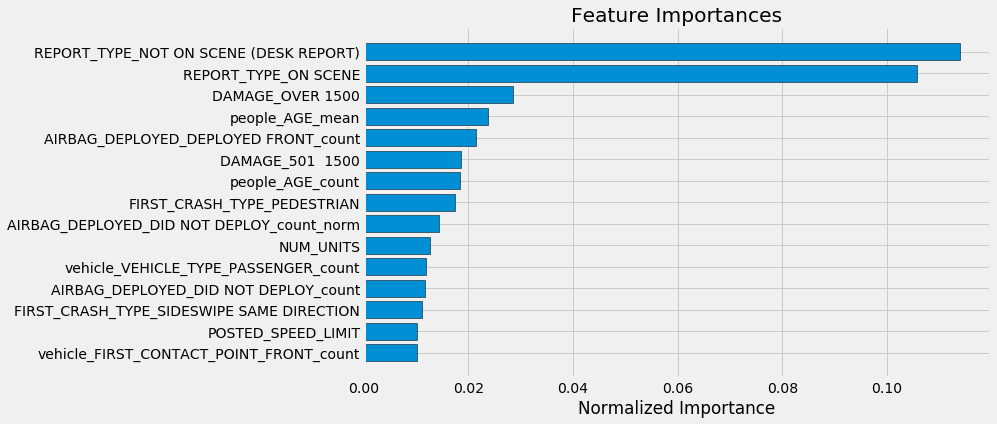

,index,feature,importance,importance_normalized
0,231,REPORT_TYPE_NOT ON SCENE (DESK REPORT),0.114001,0.114001
1,232,REPORT_TYPE_ON SCENE,0.105775,0.105775
2,235,DAMAGE_OVER 1500,0.028420,0.028420
3,4,people_AGE_mean,0.023724,0.023724
4,14,AIRBAG_DEPLOYED_DEPLOYED FRONT_count,0.021464,0.021464
...,...,...,...,...
357,9,SEX_U_count,0.000000,0.000000
358,174,LANE_CNT_19.0,0.000000,0.000000
359,188,LANE_CNT_100.0,0.000000,0.000000
360,209,LANE_CNT_902,0.000000,0.000000


In [341]:
plot_feature_importances(fi_model)

In [342]:
# Get numerical feature importances
importances = list(base_clf.feature_importances_)
feature_list = list(features)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# # Print out the feature and importances 
# f'Variable: {:20} Importance: {}.format(*pair)) for pair in feature_importances'

### Limit Number of Features
We will now reduce the number of features in use by the model to only those required to account for 95% of the importance. The same number of features must be used in the training and testing sets.

In [343]:
fi_model['cumulative_importance'] = np.cumsum(fi_model['importance'])
fi_model

,feature,importance,cumulative_importance
231,REPORT_TYPE_NOT ON SCENE (DESK REPORT),0.114001,0.114001
232,REPORT_TYPE_ON SCENE,0.105775,0.219777
235,DAMAGE_OVER 1500,0.028420,0.248197
4,people_AGE_mean,0.023724,0.271921
14,AIRBAG_DEPLOYED_DEPLOYED FRONT_count,0.021464,0.293385
...,...,...,...
9,SEX_U_count,0.000000,1.000000
174,LANE_CNT_19.0,0.000000,1.000000
188,LANE_CNT_100.0,0.000000,1.000000
209,LANE_CNT_902,0.000000,1.000000


In [373]:
print('Number of features for 95% importance:', np.where(fi_model['cumulative_importance'] > 0.95)[0][0] + 1)

Number of features for 95% importance: 171


In [375]:
# check with nunique()
fi_model[fi_model['cumulative_importance'] < 0.951]['feature'].nunique()

171

In [345]:
#check 0~171
fi_model.iloc[0:171]

,feature,importance,cumulative_importance
231,REPORT_TYPE_NOT ON SCENE (DESK REPORT),0.114001,0.114001
232,REPORT_TYPE_ON SCENE,0.105775,0.219777
235,DAMAGE_OVER 1500,0.028420,0.248197
4,people_AGE_mean,0.023724,0.271921
14,AIRBAG_DEPLOYED_DEPLOYED FRONT_count,0.021464,0.293385
...,...,...,...
263,PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN E...,0.000942,0.947087
105,TRAFFIC_CONTROL_DEVICE_UNKNOWN,0.000935,0.948022
328,CRASH_HOUR_2,0.000928,0.948951
162,LANE_CNT_6.0,0.000908,0.949858


In [346]:
fi_model.iloc[0:171].index

Int64Index([231, 232, 235,   4,  14, 234,   3, 139,  18,   1,
            ...
            126, 317, 335,  40, 271, 263, 105, 328, 162, 156],
           dtype='int64', length=171)

In [347]:
important_indices = fi_model.iloc[0:171].index

In [348]:
important_train_features = train_features.iloc[:,important_indices]
important_test_features  = test_features.iloc[:,important_indices]

## Random Forest Optimization through Random Search
In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best.

#### Random search with Cross Validation
We will set the hyperparameters randomly.

In [349]:

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num =5 )]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively). More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

This code will work but it takes too much time so we move on the GridSearch technique which is expected similar performance.

In [350]:
# Here is the code for finding RandomizedSearchCV but it never finishes with the computer. we will move on to GridSearch
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 2003, class_weight='balanced_subsample',
                                  oob_score='True')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='roc_auc', 
                              cv = 3, verbose=2, random_state=2003, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(important_train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 14.2min


KeyboardInterrupt: 

In [ ]:
#rf_random.best_params_

In [ ]:
#rf_random.scorer_

In [207]:
# auc example
# from sklearn.metrics import roc_auc_score
# y_true = np.array([0, 0, 1, 1])
# y_scores = np.array([0.1, 0.4, 0.35, 0.8])
# roc_auc_score(y_true, y_scores)

0.75

## Grid Search
We can now perform grid search building on the result from the random search. We will test a range of hyperparameters around the best values returned by base modoel.

In [278]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20,40,60,80],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 300,500, 1000]
}

# Create a base model
rf = RandomForestClassifier(random_state = 2003, class_weight='balanced',
                                  oob_score='True',n_estimators= 1000, n_jobs=-1)



# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [280]:
# Fit the grid search to the important_train_features
grid_search.fit(important_train_features, train_labels);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 91.7min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 177.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 249.0min finished


In [281]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

In [282]:
best_grid = grid_search.best_estimator_

In [284]:
grid_performance = evaluate(best_grid, important_test_features,test_labels)
grid_performance

***** Model Performance. *****
- Out of Bag eror: 0.8583.
- test_labels values: [0 0 0 0 0 0 0 0 1 0]
- predictions values: [0 0 0 0 0 0 1 0 0 0] 

<Accuracy> 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     39041
           1       0.68      0.80      0.73     12735

    accuracy                           0.86     51776
   macro avg       0.80      0.84      0.82     51776
weighted avg       0.87      0.86      0.86     51776



'              precision    recall  f1-score   support\n\n           0       0.93      0.88      0.90     39041\n           1       0.68      0.80      0.73     12735\n\n    accuracy                           0.86     51776\n   macro avg       0.80      0.84      0.82     51776\nweighted avg       0.87      0.86      0.86     51776\n'

# Random Forest Results

We will use important features only.

In [291]:
train_rf_predictions = best_grid.predict(important_train_features)
train_rf_probs = best_grid.predict_proba(important_train_features)[:, 1]

rf_predictions = best_grid.predict(important_test_features)
rf_probs = best_grid.predict_proba(important_test_features)[:, 1]

In [298]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_rf_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, rf_probs)}')

Train ROC AUC Score: 0.9618386446925643
Test ROC AUC  Score: 0.9089810378943132


In [299]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [311]:
roc_auc_score(test_labels, rf_probs)

0.9089810378943132

Recall Baseline: 1.0 Test: 0.8 Train: 0.88
Precision Baseline: 0.25 Test: 0.68 Train: 0.74
Roc Baseline: 0.5 Test: 0.91 Train: 0.96


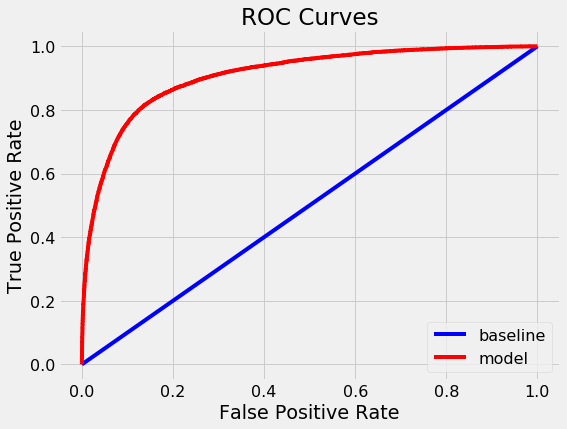

In [300]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)


## confusion matrix

In [301]:

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[34248  4793]
 [ 2597 10138]]


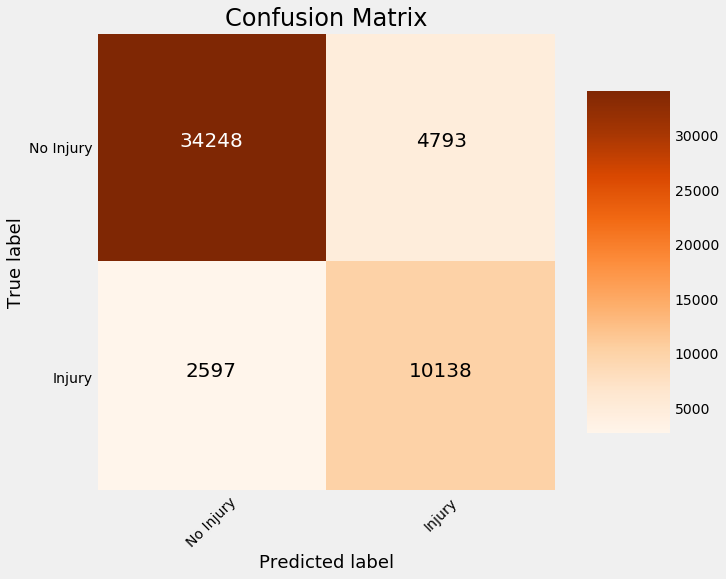

In [378]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['No Injury', 'Injury'],
                      title = 'Confusion Matrix')

In [306]:
confusion_matrix(test_labels, rf_predictions)

array([[34248,  4793],
       [ 2597, 10138]], dtype=int64)